# Robust Sequence Classification with Adapt𝒪r

This tutorial demonstrates a usage of Adapt𝒪r library for **Sequence Classification** with evaluation of **model robustness** on **adversarial dataset**.

This notebook will show you:

1. How to use a few lines of Adaptor to train a language model for sequence classification
2. How objective-centric approach eases in-training evaluation of the **robustness** of the trained model
3. Whether the longer training helps the accuracy of 

#### Requirements

In [17]:
%%capture

!pip install --upgrade adaptor==0.1.4 datasets==2.1.0

### Dataset resolution

We will use publicly-available CoNLL 2003 dataset for Named Entity Recognition, annotated on the news articles from Reuters Corpus. See e.g. [paperswithcode.com](https://paperswithcode.com/dataset/conll-2003) for more info.

## Datasets resolution

We will fit BERT with sequence classification head on MNLI: Multi-genre Natural Language Inference dataset: you can find more info about this dataset on  [HuggingFace Datasets](https://huggingface.co/datasets/multi_nli) repo.

In [40]:
from datasets import load_dataset

mnli_dataset = load_dataset("multi_nli")
mnli_dataset["train"].column_names

Using custom data configuration default
Reusing dataset multi_nli (/home/xstefan3/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39)


  0%|          | 0/3 [00:00<?, ?it/s]

['promptID',
 'pairID',
 'premise',
 'premise_binary_parse',
 'premise_parse',
 'hypothesis',
 'hypothesis_binary_parse',
 'hypothesis_parse',
 'genre',
 'label']

By changing the labels for their corresponding value, the objective's model will remember the mapping. You might find that useful, when you'd later need to reload the model only for inference.

In [51]:
label_map = {0: 'entailment', 1: 'non-entailment', 2: 'non-entailment'}

In [127]:
mnli_samples = mnli_dataset["train"].map(lambda sample: {"prem_hyp_pair": "%s\t%s" % (sample["premise"], sample["hypothesis"])})["prem_hyp_pair"]
mnli_labels = [label_map[y] for y in mnli_dataset["train"]["label"]]

Loading cached processed dataset at /home/xstefan3/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-c16e3cc89e4ac246.arrow


In [128]:
len(mnli_samples), len(mnli_labels)

(392702, 392702)

In [53]:
mnli_samples[:5]

['Conceptually cream skimming has two basic dimensions - product and geography.\tProduct and geography are what make cream skimming work. ',
 'you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him\tYou lose the things to the following level if the people recall.',
 'One of our number will carry out your instructions minutely.\tA member of my team will execute your orders with immense precision.',
 'How do you know? All this is their information again.\tThis information belongs to them.',
 "yeah i tell you what though if you go price some of those tennis shoes i can see why now you know they're getting up in the hundred dollar range\tThe tennis shoes have a range of prices."]

^^ this is a default format of `SequenceClassification` objective: 

* if the task is to classify single texts, each entry in the iterable is a single string
* if the task is to classify a **pair of texts** (NLI case), we **separate the texts with "\t" (tab) symbol**. In the case of NLI, the first text corresponds to a premise and the second to a hypothesis that we are about to decide on.

For all existing Adaptor objectives, the input format consists of a list of texts & labels, or a paths to a `.txt` files with one sample / label per line. See the base `Objective` docs.

In [54]:
mnli_labels[:5]

['non-entailment', 'entailment', 'entailment', 'entailment', 'non-entailment']

ˆ^ each label simply corresponds to a single sample.

Next, we initialise in-domain, validation and test samples:

In [124]:
val_test_mnli_samples = mnli_dataset["validation_matched"].map(lambda sample: {"prem_hyp_pair": "%s\t%s" % (sample["premise"], sample["hypothesis"])})["prem_hyp_pair"]
val_test_mnli_labels = [label_map[y] for y in mnli_dataset["validation_matched"]["label"]]

val_mnli_samples = val_test_mnli_samples[:2000]
val_mnli_labels = val_test_mnli_labels[:2000]

test_mnli_samples = val_test_mnli_samples[2000:]
test_mnli_labels = val_test_mnli_labels[2000:]

Loading cached processed dataset at /home/xstefan3/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39/cache-fe275b8de061a139.arrow


### Out-of-domain dataset

During the training, we evaluate our model for the known biases of the NLI models, that were used to compose the **[HANS dataset](https://huggingface.co/datasets/hans)**.

Although that we know that training on this data set will help your model to be more robust, now we use the data only for evaluation.

In [33]:
hans_dataset = load_dataset("hans")

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Dataset hans downloaded and prepared to /home/xstefan3/.cache/huggingface/datasets/hans/plain_text/1.0.0/452e93cf5383f5ae39088254215b517d0da98ccaaf0af8f7ab04d8f23f67dbd9. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
hans_label_map = {0: "entailment", 1: "non-entailment"}

In [70]:
hans_dataset["train"] = hans_dataset["train"].shuffle()
hans_dataset["validation"] = hans_dataset["validation"].shuffle()

hans_samples = hans_dataset["train"].map(lambda sample: {"prem_hyp_pair": "%s\t%s" % (sample["premise"], sample["hypothesis"])})["prem_hyp_pair"]
hans_labels = [hans_label_map[y] for y in hans_dataset["train"]["label"]]

val_hans_samples = hans_dataset["validation"].map(lambda sample: {"prem_hyp_pair": "%s\t%s" % (sample["premise"], sample["hypothesis"])})["prem_hyp_pair"]
val_hans_labels = [hans_label_map[y] for y in hans_dataset["validation"]["label"]]

val_hans_samples = val_hans_samples[:2000]
val_hans_labels = val_hans_labels[:2000]

  0%|          | 0/30000 [00:00<?, ?ex/s]

  0%|          | 0/30000 [00:00<?, ?ex/s]

## Training setup: single-objective NLI

Using Adaptor, we compose our training process from the selected `Objective`s. This is fairly straight with a single fine-tuning Objective.
In addition, we can use an arbirary set of compatible `Evaluator`s. You can also define your own Evaluators (as shown later below).

Adaptor Objectives provide high-level interface, expecting both the input texts and labels in a form of:
* either a `List[str]`, with the texts and labels of the matching length
* or a paths to a `.txt` files with one sample / label per line.

In this example, we perform a classification of a sequences of texts. We have prepared Objective for that in Adaptor: `SequenceClassfication` objective.

In [ ]:
from adaptor.objectives.classification import SequenceClassification
from adaptor.evaluators.sequence_classification import SequenceAccuracy
from adaptor.lang_module import LangModule

lang_module = LangModule("bert-base-cased")

evaluators = [SequenceAccuracy()]

mnli_classification = SequenceClassification(lang_module,
                                    batch_size=8,
                                    texts_or_path=mnli_samples,
                                    labels_or_path=mnli_labels,
                                    val_texts_or_path=val_mnli_samples,
                                    val_labels_or_path=val_mnli_labels,
                                    val_evaluators=evaluators,
                                    objective_id="MNLI")

It might be handy to use more than one distinct set of data for evaluation - in this example, we need this setup for evaluating model robustness to adversarial samples.
In Adaptor, you can set it up using identical interface as with the training objective(s): you just initialize another objective instance with the new texts. 

Note the `share_other_objective_head` parameter: that will point the new objective to the same head as used by given objective (`mnli_classification` here). Otherwise, a new, separate head would be randomly initialized for the evaluation `SequenceClassification` objective, that would never be fitted -- we don't want that.

In [135]:
hans_val_classification = SequenceClassification(lang_module,
                                                 batch_size=8,
                                                 texts_or_path=hans_samples,
                                                 labels_or_path=hans_labels,
                                                 val_texts_or_path=val_hans_samples,
                                                 val_labels_or_path=val_hans_labels,
                                                 share_other_objective_head=mnli_classification,
                                                 val_evaluators=evaluators,
                                                 objective_id="HANS")

Objective HANS-SequenceClassification will use SEQ_CLASSIFICATION head of MNLI-SequenceClassification objective
These layers of the loaded SEQ_CLASSIFICATION were not merged: []


Once we are done with the datasets, Objectives and evaluators, we set up the `AdaptationArguments`. These are a small extension of 🤗 's [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.TrainingArguments), the extra parameters are documented with [AdaptationArguments definition](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/utils.py#L77).

In [141]:
from adaptor.utils import StoppingStrategy, AdaptationArguments

training_arguments = AdaptationArguments(output_dir="training_checkpoints",
                                         stopping_strategy=StoppingStrategy.ALL_OBJECTIVES_NUM_EPOCHS,
                                         do_train=True,
                                         do_eval=True,
                                         gradient_accumulation_steps=4,
                                         evaluation_strategy="steps",
                                         logging_steps=100,
                                         eval_steps=100,
                                         num_train_epochs=5,
                                         save_steps=1000)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Then, we define a `Schedule`, defining an order of application of selected `Objective`s. If our training is a single-objective, we can pick any Schedule available - it makes no difference.

Note the `extra_eval_objectives` argument here, where we separately list all objectives used only to produce the validation logs for their evaluators.

In [142]:
from adaptor.schedules import SequentialSchedule

schedule = SequentialSchedule(objectives=[mnli_classification], 
                              extra_eval_objectives=[hans_val_classification],
                              args=training_arguments)

Total number of train samples: 392702
Total number of eval samples: 4000


Finally, we define a main object called `Adapter`: this is again merely a small adjustment of 🤗  [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.Trainer), that takes care of data iteration according to selected `Schedule`, collection of `Objective`s' logs or applying selected multi-objective early-stopping strategy.

In [143]:
from adaptor.adapter import Adapter

adapter = Adapter(lang_module, schedule, training_arguments)

Having the identical iterface, we initialize the training in the same way as with 🤗 Trainer and run the training:

In [ ]:
adapter.train()  # logs are dropped to keep it tidy

## Training logs analysis

Once the training reaches the `stopping_strategy` given in `AdaptationArguments`, the training iteration is terminated and we can take a look at the results.

Using the per-objective logs of the training with Adaptor, we may answer two questions: **1. does longer fine-tuning helps the robustness of the final model?** and **2. is the early-stopping based on in-domain metrics optimal for choosing the most-robust model?**

Objectives remember their own states, which can also be used in custom `Schedule` implementations.

Specifically, the logs are persisted in `evaluations_history` of each Objective instance, so for the simplicity, we will work with that here. But commonly, you would perhaps rather do the loggs analyses more conveniently in Tensorboard, or Comet.ml.

<AxesSubplot:>

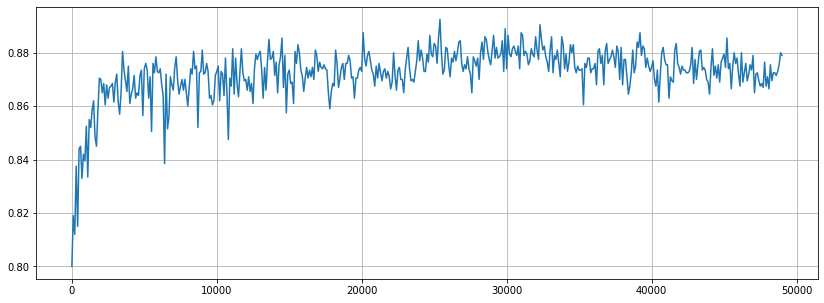

In [160]:
import pandas as pd

mnli_accuracies = pd.Series(mnli_classification.evaluations_history['eval'][evaluators[0]])
hans_accuracies = pd.Series(hans_val_classification.evaluations_history['eval'][evaluators[0]])

index = range(0, len(mnli_accuracies)*training_arguments.eval_steps, training_arguments.eval_steps)
mnli_accuracies.index = index
hans_accuracies.index = index

mnli_accuracies.plot(figsize=(14, 5), grid=True, ylim=(0.7, 0.9))

So the early-stopping based on validation accuracy would perhaps yield the `checkpoint-25000` as the best one.

<AxesSubplot:>

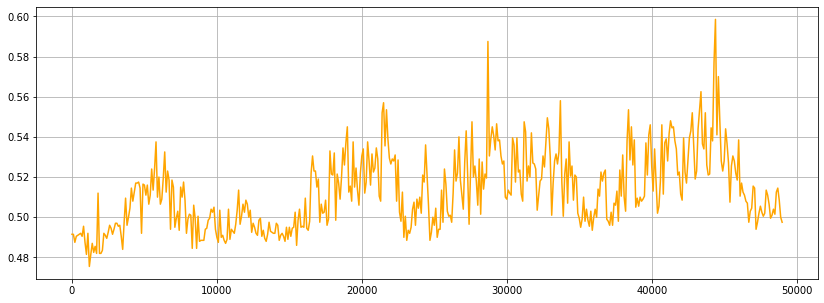

In [161]:
hans_accuracies.plot(figsize=(14, 5), grid=True, color="orange")

But the robustness evaluation on `checkpoint-25000` does not seem particularly shiny. We got only somewhere close above random 0.5 here. But we also got much better evaluations, so the answer to our posed **Question 2** is **false**.

We'll align the MNLI and HANS plot by the change of the accuracy respective to the initial value, to assess **alignment of the trends** of the both.

<AxesSubplot:>

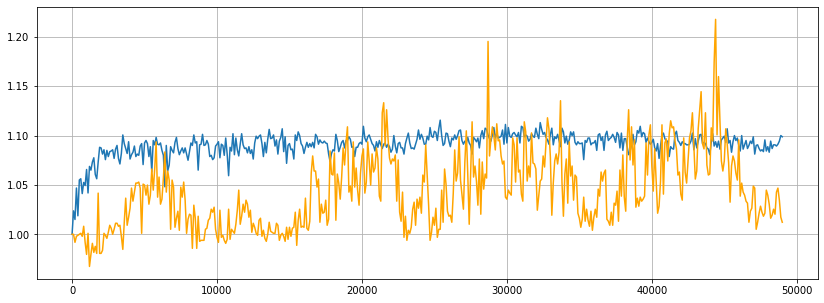

In [162]:
rel_mnli_accuracies = mnli_accuracies / mnli_accuracies[0]
rel_hans_accuracies = hans_accuracies / hans_accuracies[0]

rel_mnli_accuracies.plot(figsize=(14, 5), grid=True, label="Change in MNLI val accuracy")
rel_hans_accuracies.plot(figsize=(14, 5), grid=True, color="orange", label="Change in HANS val accuracy")

It seems that MNLI objective reaches stable maxima somewhere around 30k-th step and then starts to slowly drop. HANS seems to oscilate but improves slightly further after each iteration of such oscilation, lasting around 10k steps.

If we were to dig into this deeper, we might want to 
* try to train on MNLI for longer than 5 epochs
* increase a size of validation set of HANS, to smoothen the logs even for its price of a slight additional overhead with evaluation.

From what we have seen, we incline to answer the **question 1** by saying that longer tuning indeed **does** improve model robustness, which is consistent with some literature (see e.g. [Tu, L et at.; 2020](https://aclanthology.org/2020.tacl-1.40)), and also somewhat makes sense intuitively: it is quick to eliminate a large portion of the loss by modeling the simple surface-level relations, but further reduction is not possible without modeling deeper aspects of even in-domain dataset. 

But to be rigorous, more experimentation is needed to confirm this in our use-case.

## Training setup: multi-objective NLI

Now we'll see what happens if we mix the MNLI data with a train split of HANS.

We can do that conveniently, with a separate logs tracking by using the identically-initialised objectives, like in the first case. But to remember each objective's logs, we'll create a new one

In [166]:
from adaptor.objectives.classification import SequenceClassification
from adaptor.evaluators.sequence_classification import SequenceAccuracy
from adaptor.lang_module import LangModule

lang_module = LangModule("bert-base-cased")

evaluators = [SequenceAccuracy()]

mnli_classification_multi = SequenceClassification(lang_module,
                                                   batch_size=8,
                                                   texts_or_path=mnli_samples,
                                                   labels_or_path=mnli_labels,
                                                   val_texts_or_path=val_mnli_samples,
                                                   val_labels_or_path=val_mnli_labels,
                                                   val_evaluators=evaluators,
                                                   objective_id="MNLI")

loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /home/xstefan3/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.10.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file https://huggingface.co/bert-base-cased/resolve/main/vocab.txt from cache at /home/xs

In [167]:
hans_train_classification = SequenceClassification(lang_module,
                                                   batch_size=8,
                                                   texts_or_path=hans_samples,
                                                   labels_or_path=hans_labels,
                                                   val_texts_or_path=val_hans_samples,
                                                   val_labels_or_path=val_hans_labels,
                                                   share_other_objective_head=mnli_classification_multi,
                                                   val_evaluators=evaluators,
                                                   objective_id="HANS")

Objective HANS-SequenceClassification will use SEQ_CLASSIFICATION head of MNLI-SequenceClassification objective
These layers of the loaded SEQ_CLASSIFICATION were not merged: []


Once we are done with the datasets, objectives and evaluators, we set up the `AdaptationArguments`. These are a small extension of 🤗 's [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.TrainingArguments), the extra parameters are documented with [AdaptationArguments definition](https://github.com/gaussalgo/adaptor/blob/db33e6e439babc68fe801a8946d87116ff44f170/adaptor/utils.py#L77).

In [168]:
from adaptor.utils import StoppingStrategy, AdaptationArguments

training_arguments = AdaptationArguments(output_dir="training_checkpoints",
                                         stopping_strategy=StoppingStrategy.ALL_OBJECTIVES_NUM_EPOCHS,
                                         do_train=True,
                                         do_eval=True,
                                         gradient_accumulation_steps=4,
                                         evaluation_strategy="steps",
                                         logging_steps=100,
                                         eval_steps=100,
                                         num_train_epochs=5,
                                         save_steps=1000)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Then, we define a `Schedule`, defining an order of application of selected `Objective`s. If our training is a single-objective, we can pick any Schedule available - it makes no difference.

In [169]:
from adaptor.schedules import ParallelSchedule

schedule = ParallelSchedule(objectives=[mnli_classification_multi, hans_train_classification], 
                              args=training_arguments)

Total number of train samples: 422702
Total number of eval samples: 4000


Finally, we define a main object called `Adapter`: this is again merely a small adjustment of 🤗  [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer?highlight=launch#transformers.Trainer), that takes care of data iteration according to selected `Schedule`, collection of `Objective`s' logs or applying selected multi-objective early-stopping strategy.

In [170]:
from adaptor.adapter import Adapter

adapter = Adapter(lang_module, schedule, training_arguments)

Having the identical iterface, we initialize the training in the same way as with 🤗 Trainer.

## Logs analysis

Similarly to the single-objective case above, we'll take a look at how the accuracies of each of the datasets developed.
Thanks to the distinctions by datasets, we now have **separate logs** for each domain.

If we were using some of the loggings supported by 🤗  Transformers, we would also see such distinction in Tensorboard, Comet.ml, or Weights&Biases.

<AxesSubplot:>

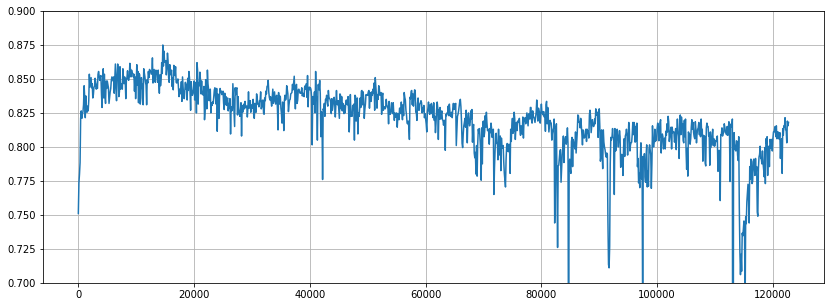

In [191]:
import pandas as pd
import matplotlib.pyplot as plt

# here we just exchange the objective for the new ones
mnli_accuracies = pd.Series(mnli_classification_multi.evaluations_history['eval'][evaluators[0]])
hans_accuracies = pd.Series(hans_train_classification.evaluations_history['eval'][evaluators[0]])

index = range(0, len(mnli_accuracies)*training_arguments.eval_steps, training_arguments.eval_steps)
mnli_accuracies.index = index
hans_accuracies.index = index

mnli_accuracies.plot(figsize=(14, 5), grid=True, ylim=(0.7, 0.9))

It seems that MNLI trained together with HANS fits earlier. However, note that the training is now longer, since the data is instead sampled from two objectives. The absolute values of evaluations around 20k-th step, where the multi-objective training plateaus, still have similar values to the Single-objective sibling -- around 87%.

<AxesSubplot:>

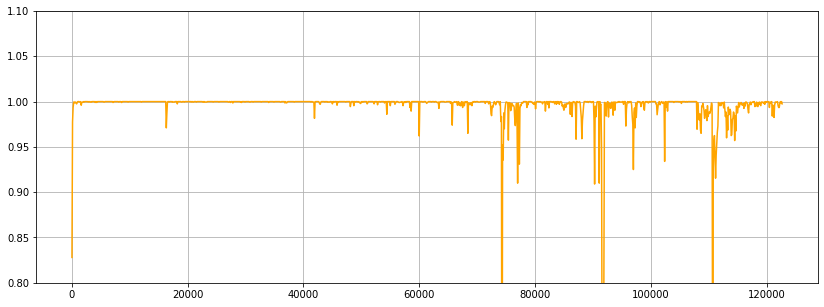

In [215]:
hans_accuracies.plot(figsize=(14, 5), grid=True, color="orange", ylim=(0.8, 1.1))

Thanks to the per-dataset separation of the accuracy logs given by separate objectives, we see that HANS is surprisingly simple to fit.

We can not be sure, but this can be the case for the data set composed of the samples following merely a small set of heuristics. This would definitely worth further investigation, but we'll presume for now that the validaiton set of HANS is built properly and there are not data leakages or other artifacts.

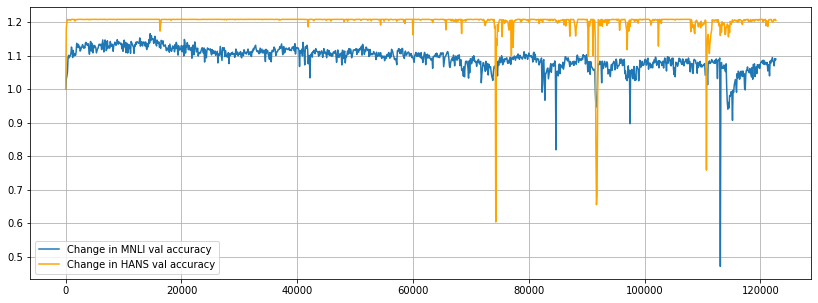

In [187]:
rel_mnli_accuracies = mnli_accuracies / mnli_accuracies[0]
rel_hans_accuracies = hans_accuracies / hans_accuracies[0]

rel_mnli_accuracies.plot(figsize=(14, 5), grid=True, label="Change in MNLI val accuracy")
rel_hans_accuracies.plot(figsize=(14, 5), grid=True, color="orange", label="Change in HANS val accuracy")

plt.legend()
plt.show()

### A price of in-domain accuracy with multi-objective training

So how much accuracy does it cost us to train the model **robust** to HANS's heuristics?

We'll look at the **difference** between the **MNLI validation** between the **single-objective** and **multi-objective training** (including HANS).

In [200]:
# note that we take the logs of the objective from the first, single-objective training:

# slightly more complicated, because we've overriden our `evaluators` variable
single_objective_mnli_accuracies = pd.Series(next(vals for evaluator_obj, vals in mnli_classification.evaluations_history['eval'].items() if "SequenceAccuracy" in str(evaluator_obj)))

single_objective_mnli_accuracies.index = range(0, len(single_objective_mnli_accuracies)*training_arguments.eval_steps, training_arguments.eval_steps)

In [212]:
# but we still remember the multi-objective evaluations
multi_objective_mnli_accuracies = mnli_accuracies

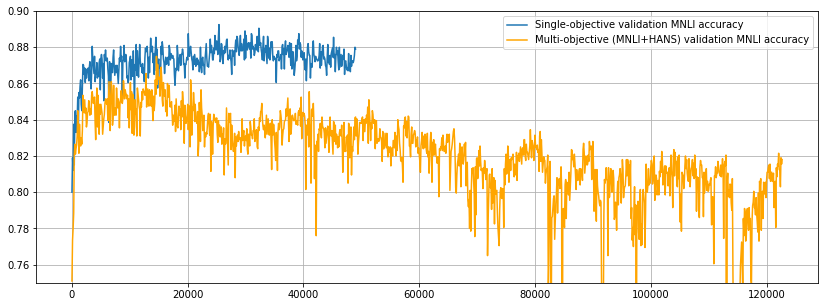

In [213]:
single_objective_mnli_accuracies.plot(label="Single-objective validation MNLI accuracy")
multi_objective_mnli_accuracies.plot(figsize=(14, 5), grid=True, ylim=(0.75, 0.9), color="orange", label="Multi-objective (MNLI+HANS) validation MNLI accuracy")

plt.legend()
plt.show()

Okay, so the best validations of Multi-objective training reach above **86%** of accuracy, while the Single-objective ones reach above **88%** -- we conclude that the **elimination of the known biases** from MNLI training, that are normalized in HANS hence **costs us around 2% of accuracy**.